In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler

cmap=plt.cm.tab10
c = cycler('color', cmap(np.linspace(0,1,10)))
plt.rcParams["axes.prop_cycle"] = c

%config InlineBackend.figure_format = 'retina'
%matplotlib notebook

from sodapy import Socrata
import folium
import json
import utils

In [3]:
%matplotlib notebook
%matplotlib notebook

In [4]:
client = Socrata('data.cityofnewyork.us', None, timeout=100)

In [23]:
population_data = pd.read_json('https://api.census.gov/data/2015/acs5?get=ZCTA5,B01003_001E&for=zip+code+tabulation+area:*')
population_data.columns = population_data.iloc[0]
population_data = population_data.iloc[1:]
population_data.rename(columns={'B01003_001E':'population', 'zip code tabulation area':'zcta'}, inplace=True)
population_data.drop(['ZCTA5'], 1, inplace=True)

In [26]:
population_data.head()

,population,zcta
1,17982,00601
2,40260,00602
3,52408,00603
4,6331,00606
5,28328,00610


## Rats! 

In [27]:
%%time

data = pd.DataFrame(\
         client.get('fhrw-4uyv',
         select='date_trunc_ym(created_date) as month, incident_zip as zcta, count(*) as num_rats',
         where="descriptor in ('Rat Sighting', 'Mouse Sighting', 'Signs of Rodents') and incident_zip >= '10001'",
         group='incident_zip, month',
         limit=1000000))

data['zcta'] = data.zcta.apply(lambda x: x.split('-')[0])
data['num_rats'] = data.num_rats.astype(int)

data.index = pd.to_datetime(data.month)
data.drop(['month'], 1, inplace=True)

data = data['2010':'2017']

CPU times: user 67.7 ms, sys: 758 µs, total: 68.4 ms
Wall time: 278 ms


In [29]:
data.head()

,num_rats,zcta
month,,
2016-03-01,2,10308
2017-09-01,19,10312
2016-02-01,9,10454
2016-08-01,14,10012
2015-04-01,1,10453


In [30]:
data.merge(population_data,on='zcta', how='left')

,num_rats,zcta,population
0,2,10308,29766
1,19,10312,62032
2,9,10454,39012
3,14,10012,24163
4,1,10453,80081
5,10,10473,59352
6,14,10305,41795
7,12,11379,35476
8,2,10033,59844
9,4,11103,39231


## maps

### seasonal affects on population 

<IPython.core.display.Javascript object>


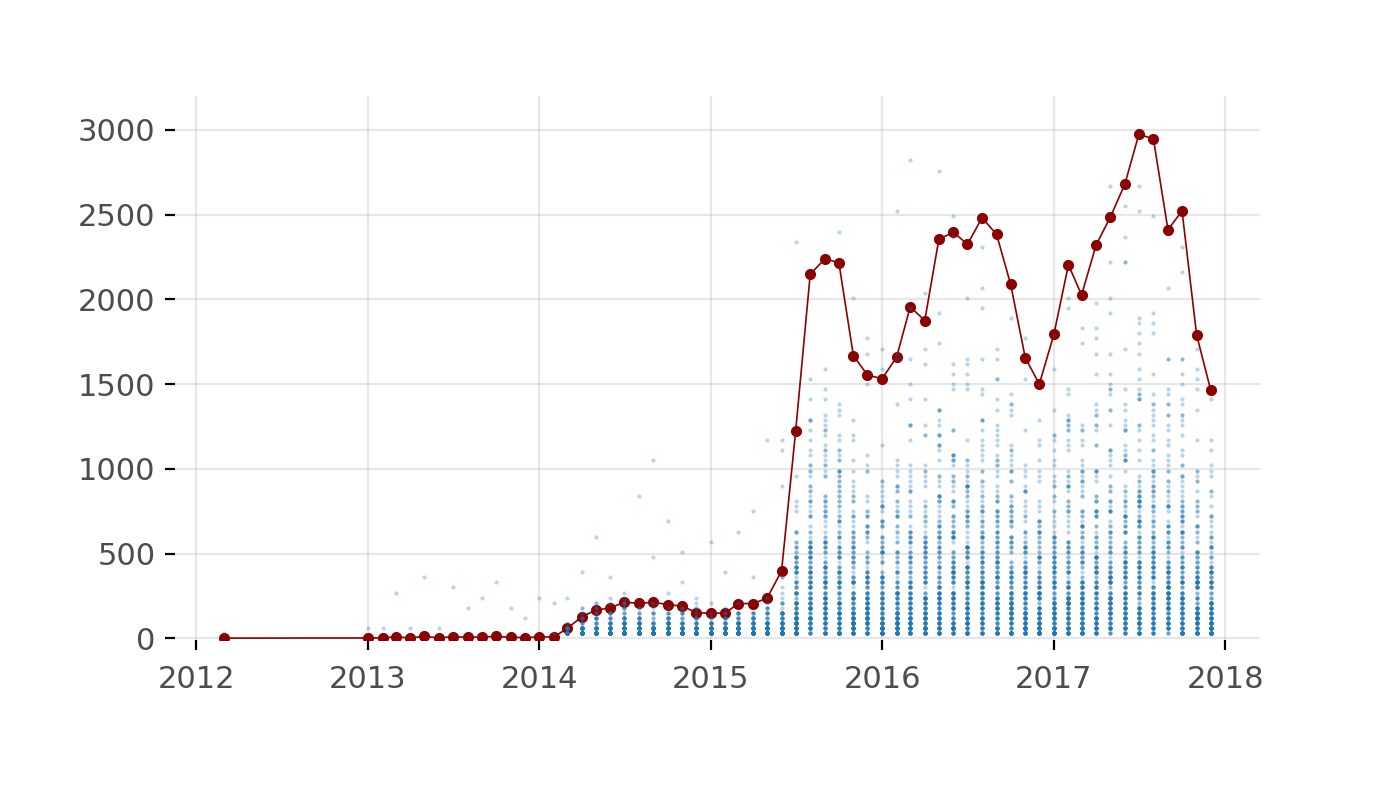

In [14]:
fig, ax = plt.subplots(figsize=(7,4))
data.groupby(data.index).sum().plot(ax=ax, marker='.', lw=0.6, color='darkred',legend=False)
(30*data).plot(ax=ax, marker='.', markersize=1., alpha=0.3, ls='',label='30 x complaints by zip',legend=False)
# leg = ax.legend(['Total number of roddent complaints'],frameon=False, fontsize=11)
ax.set_xlabel('')
ax.set_ylim(-10,3200)

# for text in leg.get_texts():
#     plt.setp(text, alpha = 0.8)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.grid(alpha=0.3)

ax.set_xticklabels(range(2012, 2019), rotation = (0), fontsize = 11, ha='center', y=-0.01, alpha=0.7)
ax.set_yticklabels(range(-500,3500,500), fontsize = 11, x=-0.0, alpha=0.7);

#plt.savefig('/home/rag394/timeline_total.pdf')

<IPython.core.display.Javascript object>


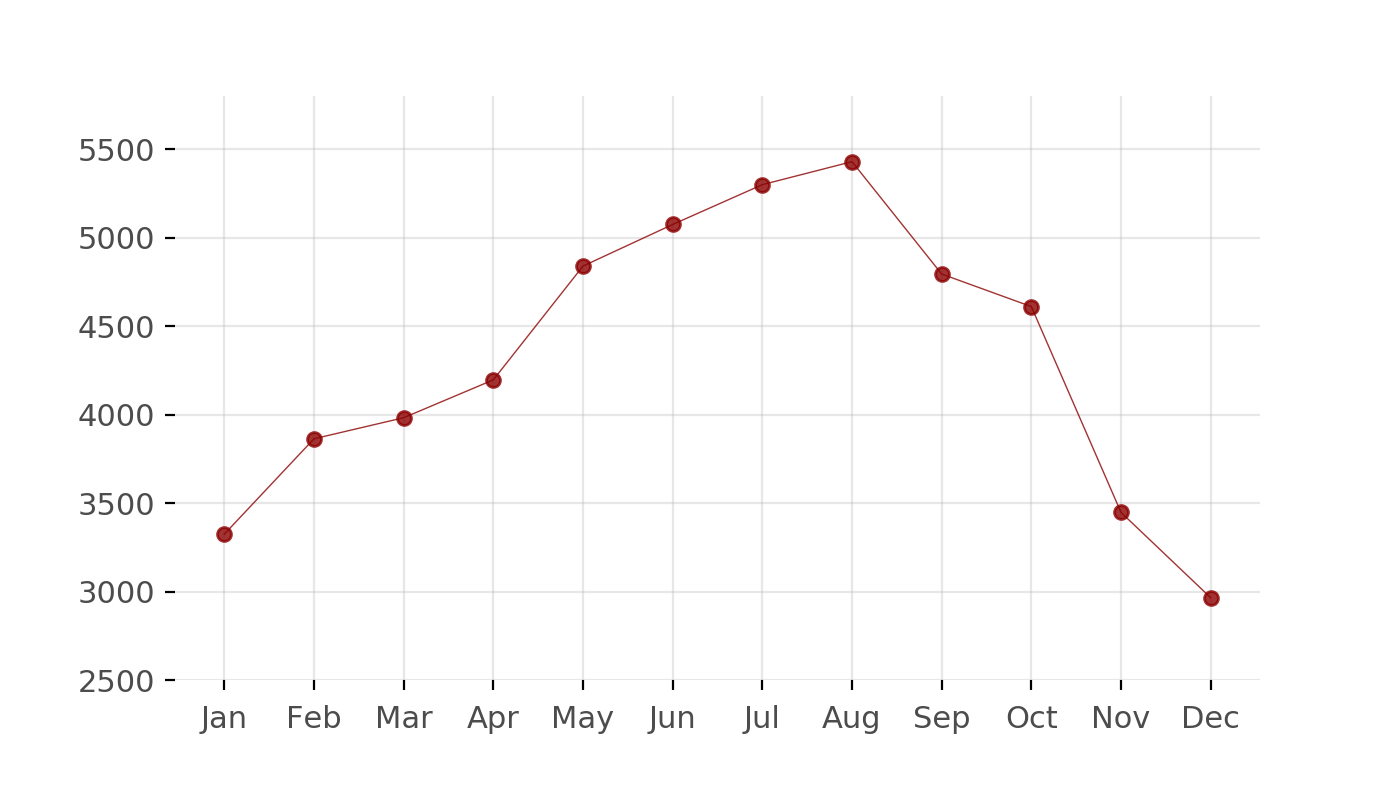

In [13]:
months = ['Jan', 'Feb','Mar', 'Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

fig, ax = plt.subplots(figsize=(7,4))
data['2016':'2017'].groupby(data['2016':'2017'].index.month).sum().plot(ax=ax,marker='.', lw=0.5, markersize=10.,color='darkred',alpha=0.8,legend=False)

#leg = ax.legend([''],frameon=False, fontsize=11, loc=(0.06 ,0.04))

# for text in leg.get_texts():
#     plt.setp(text, alpha = 0.8)

ax.set_xlabel('')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_alpha(False)
ax.grid(alpha=0.3)

ax.set_ylim(2500,5800)

plt.xticks(data['2016':'2017'].groupby(data['2016':'2017'].index.month).sum().index.values, months, rotation=0, fontsize = 11, ha='center', y=-0.01,alpha=0.7);
ax.set_yticklabels(range(2500,6500,500), fontsize = 11, x=-0.0, alpha=0.7)
plt.gcf().subplots_adjust(bottom=0.15)
#plt.savefig('/home/rag394/total_month.pdf')

In [70]:
total_zcta = data['2016':'2017'].groupby('zcta').sum()
total_zcta = total_zcta[total_zcta.num_rats>10]
total_zcta.reset_index(inplace=True)

In [74]:
threshold = list(np.linspace(0, total_zcta.num_rats.max(), 6, dtype=int))

ny_map = folium.Map(location=[40.70, -73.92],
                    width='90%', height='100%',
                    tiles="cartodbpositron",
                    detect_retina=True,
                    zoom_start=11)

ny_map.choropleth(geo_data='/scratch/rag394/data/geospatial/nyu.json',
                  data=total_zcta,
                  columns=['zcta', 'num_rats'],
                  key_on='feature.properties.zcta',
                  fill_color='YlGnBu', 
                  threshold_scale=threshold,
                  fill_opacity=0.7, 
                  line_opacity=1.0,
                  legend_name='number rats')

ny_map.save('/home/rag394/2016_2017.html')
ny_map

In [51]:
from branca.colormap import linear

colormap = linear.YlGn.scale(
    total_zcta.num_rats.min(),
    total_zcta.num_rats.max())

print(colormap(5.0))

colormap

#ffffcc


In [73]:
geo_json_data['features']['properties']['zcta']

'10001'

In [75]:
lat_init, long_init = utils.lat_long('3 washington square village NYC')
ny_map = folium.Map(location=[lat_init, long_init],
                    width='90%', height='100%',
                    tiles="Stamen Toner",
                    detect_retina=True,
                    zoom_start=14)

folium.GeoJson(
    geo_json_data,
    name='number of rats',
    style_function=lambda feature: {
        'fillColor': colormap(total_zcta.set_index('zcta')['num_rats'][feature['properties']['zcta']]),
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5',
        'fillOpacity': 0.9,
    }
).add_to(ny_map)

folium.LayerControl().add_to(ny_map)

ny_map

KeyError: '10020'